In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

2024-09-09 13:13:26.393877: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-09 13:13:26.401956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 13:13:26.411767: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 13:13:26.414608: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 13:13:26.422237: I tensorflow/core/platform/cpu_feature_guar

Resolução da EDO

$ m\frac{d²x}{dt²} + kx = 0, t_{0} = 0, x(0) = 0, x'(0) = 1$

Onde m = 0,5 kg e k = 200 N/m

Solução exata da EDO:

$ \frac{sin(20t)}{20} $

Nesse arquivo estou usando 5 pontos de dados e o fenômeno físico

I0000 00:00:1725898407.411706 1337712 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725898407.433218 1337712 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725898407.433357 1337712 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725898407.434878 1337712 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

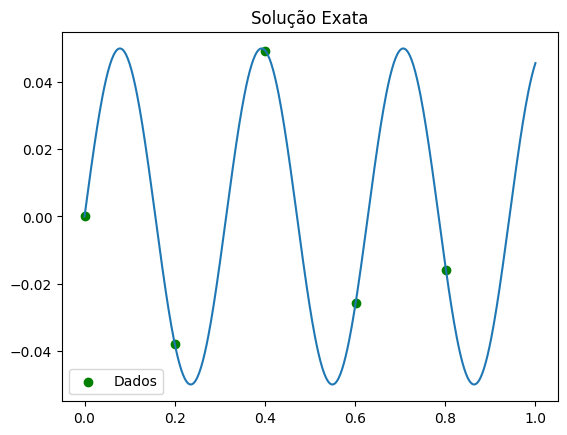

In [2]:
def sExata(t):
    x = np.sin(20*t)/20
    return x

t = np.linspace(0, 1 , 500)
t = tf.cast(t, tf.float32)
t = tf.expand_dims(t, 1)

x = sExata(t)

t_data = t[0:500:100]
x_data = x[0:500:100]

plt.title("Solução Exata")
plt.plot(t, x)
plt.scatter(t_data, x_data, label = "Dados", c = 'g')
plt.legend()
plt.show()

In [3]:
t_fis = tf.linspace(0, 1 , 500)
t_fis = tf.cast(t_fis, tf.float32)
t_fis = tf.expand_dims(t_fis, 1)

t0 = tf.zeros(t_fis.shape)

tf.random.set_seed(42)
lr = 0.001
epochs = 10000

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation = 'tanh', use_bias=True, bias_initializer='ones'),
    tf.keras.layers.Dense(32, activation = 'tanh'),
    tf.keras.layers.Dense(64, activation = 'tanh'),
    tf.keras.layers.Dense(1, activation = 'linear')
])

optimizer = tf.keras.optimizers.Adam(learning_rate = lr)

def fData_loss(y_true, y_pred):
  with tf.GradientTape() as tape:
    tape.watch(t_data)
    x_pred = model(t_data)
    data_l = tf.reduce_mean(tf.square(x_data - x_pred))

    # Derivadas para resolver a EDO
    with tf.GradientTape() as divl:
      divl.watch(t_fis)
      with tf.GradientTape() as div2:
        div2.watch(t_fis)
        x_fis = y_pred
        x_fis = model(t_fis)
        xdt = div2.gradient(x_fis, t_fis)
    xdtt = divl.gradient(xdt, t_fis)

    # Cálculo da EDO
    fis = 0.5*xdtt + 200*x_fis

    # Derivada para condições iniciais
    with tf.GradientTape() as init:
      init.watch(t0)
      x0 = model(t0)
      x0dt = init.gradient(x0, t0)

    # Losses
    loss_init_X0 = tf.reduce_mean(tf.square(x0))
    loss_init_X0DT =  tf.reduce_mean(tf.square(x0dt-1))
    fis_l = tf.reduce_mean(tf.square(fis))
    loss = fis_l + (1e5)*(data_l + loss_init_X0 + loss_init_X0DT)
    grads = tape.gradient (loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss, fis_l, data_l

model.compile(optimizer = optimizer, loss = fData_loss, metrics=[fData_loss])

history = model.fit(t_fis, sExata(t_fis), epochs = epochs, verbose = 0)

I0000 00:00:1725898409.456939 1337813 service.cc:146] XLA service 0x7c5688003f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725898409.456964 1337813 service.cc:154]   StreamExecutor device (0): NVIDIA T400 4GB, Compute Capability 7.5
2024-09-09 13:13:29.507548: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-09 13:13:29.721327: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-09-09 13:13:34.456085: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility package

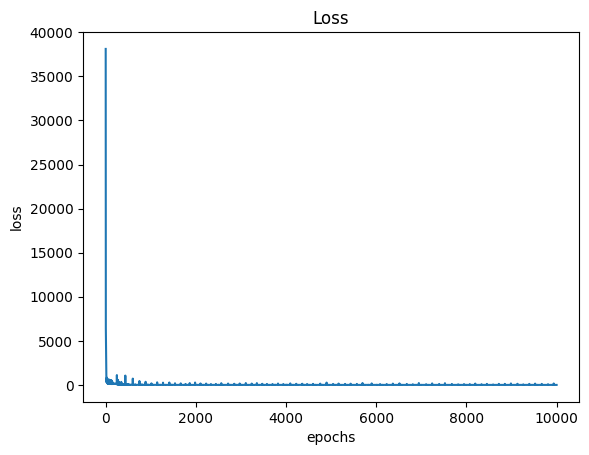

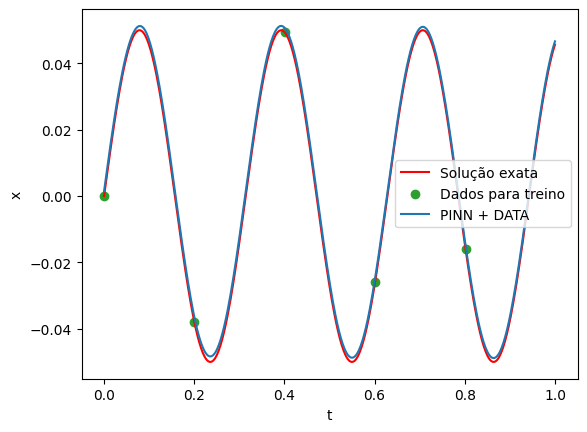

In [4]:
plt.figure()
plt.title('Loss')
plt.plot(history.history['loss'])
plt.xlabel('epochs');plt.ylabel('loss')

plt.figure()
plt.plot(t, x,'r', label="Solução exata")
plt.scatter(t_data, x_data, color="tab:green", label="Dados para treino")
plt.plot(t_fis,model(t_fis),label="PINN + DATA")
plt.xlabel('t');plt.ylabel('x')
plt.legend()